<a href="https://colab.research.google.com/github/rohaan-ahmed/Master-Repository/blob/master/Anomaly%20Detection/LSTM_Autoencoder_for_Video_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5268 sha256=88ca7692b1759f8ada813dc2776d83e1f04f645494e2fedabdb8c5a51d58f11f
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization


In [ ]:
class Config:
  DATASET_PATH ="/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/Train"
  SINGLE_TEST_PATH = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/Test/Test032"
  BATCH_SIZE = 1
  EPOCHS = 100
  MODEL_PATH = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/saved_models/model_pretrained.hdf5"
  VIDEO_PATH = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/videos"

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    i = 0
    for f in sorted(listdir(Config.DATASET_PATH)):
      print(listdir(Config.DATASET_PATH))
      i += 1
      if (i > 10):
        break
      if isdir(join(Config.DATASET_PATH, f)):
          all_frames = []
          # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
          for c in sorted(listdir(join(Config.DATASET_PATH, f))):
              if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "png":
                  img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                  img = np.array(img, dtype=np.float32) / 256.0
                  all_frames.append(img)
          print(len(all_frames))
          # get the 10-frames sequences from the list of images after applying data augmentation
          for stride in range(1, 3):
              clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips



    

In [ ]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    #seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(TimeDistributed(Conv2D(64, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 
    model_filepath = Config.MODEL_PATH
    save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min')
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), metrics=['accuracy'])
    print('training set length ' + str(len(training_set)))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False, callbacks=[es, save_best])
    seq.save(Config.MODEL_PATH)
    return seq

In [ ]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "png":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [ ]:
import matplotlib.pyplot as plt

def evaluate():
    model = get_model(False) # False = Load Model, True = Retrain Model
    print("Acquired Model")
    test = get_single_test()
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("Acquired Single Test Data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # # plot the regularity scores
    # plt.plot(sr)
    # plt.ylabel('regularity score Sr(t)')
    # plt.xlabel('frame t')
    # plt.show()

    return reconstructed_sequences, sequences, sr


In [ ]:
reconstructed_sequences, sequences, regularity_score = evaluate()

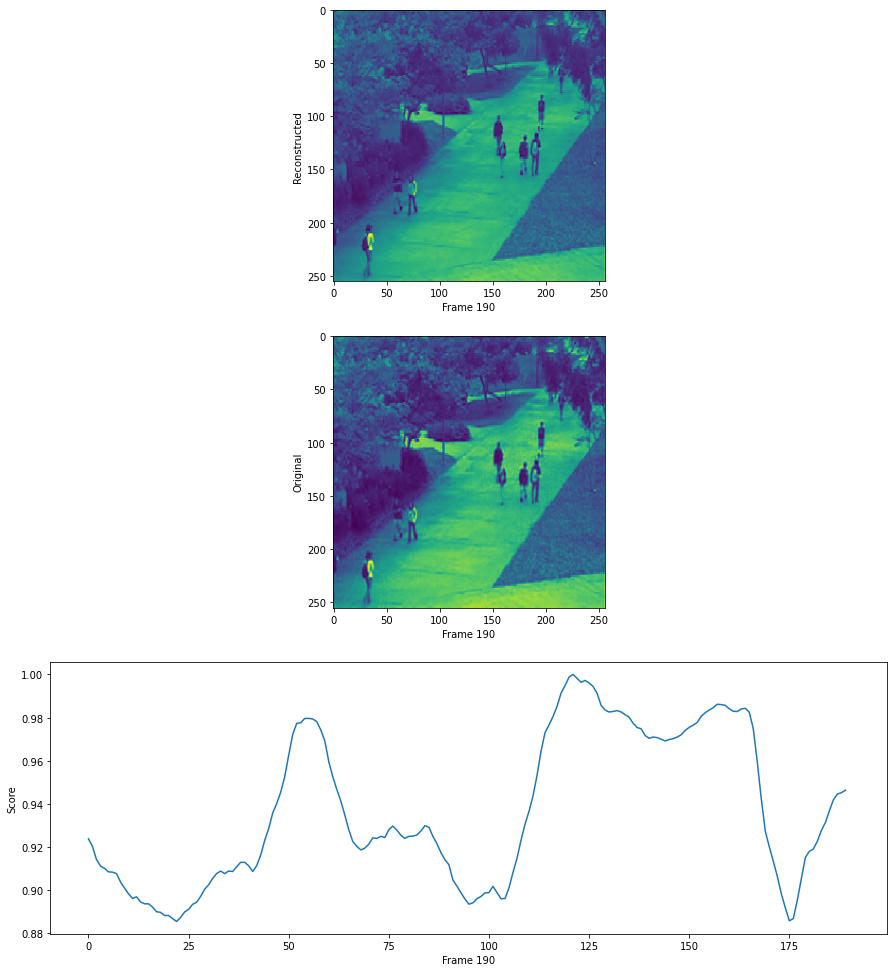

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML, Image, IFrame

fig5, (ax1, ax2, ax3) = plt.subplots(3)

fig5.set_figheight(17)
fig5.set_figwidth(15)

ax1.set_ylabel('Reconstructed')
ax1.set_xlabel('Frame %s' % 0)
ax2.set_ylabel('Original')
ax2.set_xlabel('Frame %s' % 0)
ax3.set_ylabel('Score')
ax3.set_xlabel('Frame %s' % 0)

ims_o = ax1.imshow(sequences[0,0,:,:,0])
ims_r = ax2.imshow(reconstructed_sequences[0,0,:,:,0])

regularity_score.reshape(1,-1)
x = np.arange(0, len(regularity_score), 1)
line, = ax3.plot(x, regularity_score)

def animate(i):
    line.set_ydata(regularity_score[0:i])  # update the data.
    line.set_xdata(x[0:i])  # update the data.
    ims_r.set_data(reconstructed_sequences[i,0,:,:,0])  # update the data
    ims_o.set_data(sequences[i,0,:,:,0])
    ax1.set_xlabel('Frame %s' % i)
    ax2.set_xlabel('Frame %s' % i)
    ax3.set_xlabel('Frame %s' % i)
    return line, ims_o, ims_r,

ani5 = animation.FuncAnimation(fig5, animate, interval=50, save_count = len(regularity_score), blit=True, repeat = True)

ani5.save(Config.VIDEO_PATH + "/combined_video.mp4")
HTML(ani5.to_html5_video()) 

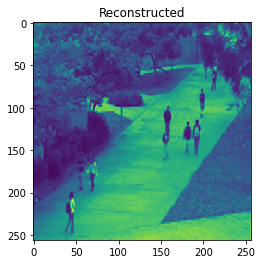

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML, Image

fig2 = plt.figure()
plt.title('Reconstructed')

ims_r = []
for i in range (0,len(reconstructed_sequences),5):
    for j in range (0,len(reconstructed_sequences[i]),5):
      im_r = plt.imshow(reconstructed_sequences[i,j,:,:,0], animated = True)
      ims_r.append([im_r])

ani1 = animation.ArtistAnimation(fig2, ims_r, interval=100, blit=True, repeat = True,
                                repeat_delay=100)
ani1.save(Config.VIDEO_PATH + "/reconstructed_sequences32.mp4")
HTML(ani1.to_html5_video()) 

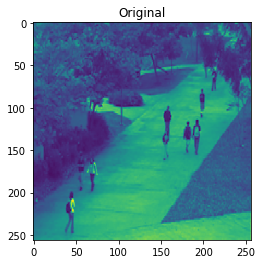

In [ ]:
fig3 = plt.figure()
plt.title('Original')

ims = []
for i in range (0,len(reconstructed_sequences),5):
    for j in range (0,len(reconstructed_sequences[i]),5):
      im = plt.imshow(sequences[i,j,:,:,0], animated = True)
      ims.append([im])

ani2 = animation.ArtistAnimation(fig3, ims, interval=100, blit=True, repeat = True,
                                repeat_delay=100)
ani2.save(Config.VIDEO_PATH + "/original_sequences32.mp4")
HTML(ani2.to_html5_video()) 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import display, clear_output, HTML, Image

# fig3 = plt.figure()
# plt.title('regularity score Sr(t)')
# plt.ylabel('regularity score Sr(t)')
# plt.xlabel('frame t')

# regularity_score.reshape(1,-1)

# x = np.arange(0, len(regularity_score), 1)
# line, = plt.plot(x, regularity_score)

# def animate(i):
#     line.set_ydata(regularity_score[0:i])  # update the data.
#     line.set_xdata(x[0:i])  # update the data.
#     return line,

# ani3 = animation.FuncAnimation(fig3, animate, interval=100, blit=True, repeat = True,
#                                 repeat_delay=100)

# HTML(ani3.to_html5_video()) 
# ####
